In [2]:
import wfdb
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from scipy.stats import median_abs_deviation

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix

### Importing AFDB

In [18]:
records = []
properties = []
annot = []
AnnSymb = []
AnnSamp = []
AnnRhythm = []
Rpeak_Samp = []
Rpeak_Symb = []

path = os.getcwd()
print(path)


for f in glob.glob('/Users/vegy-math808y/Library/CloudStorage/OneDrive-ITCenterFyn/veltek/e22/speciale/eksempler/atrial-fibrillation-detection-ijmedi-paper-main/data/*.dat'): 
    ##### change the path to own directory.       

    #for f in glob.glob('/data/*.dat'): ##### change the path to own directory.       
                                        ##### The rest should remin the same

    sig, fields = wfdb.rdsamp(f[:-4], channels=[1])  #### In this function, pass 
                                                     #### "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records.append(sig)
    properties.append(fields)
    annot.append(ann)
    AnnSymb.append(Symb)
    AnnSamp.append(Samp)
    Rpeak_Symb.append(QRS_Symb)
    Rpeak_Samp.append(QRS_Samp)
    AnnRhythm.append(Rhythm)
    
AnnSymb = pd.Series(AnnSymb).values
AnnSamp = pd.Series(AnnSamp).values


/Users/vegy-math808y/Library/CloudStorage/OneDrive-ITCenterFyn/veltek/e22/speciale/eksempler/atrial-fibrillation-detection-ijmedi-paper-main
[0    +
 1    +
 2    +
 3    +
 4    +
 5    +
 6    +
 dtype: object 0     +
               1     +
               2     +
               3     +
               4     +
               5     +
               6     +
               7     +
               8     +
               9     +
               10    +
               11    +
               12    +
               13    +
               14    +
               15    +
               16    +
               dtype: object 0     +
                             1     +
                             2     +
                             3     +
                             4     +
                                  ..
                             74    +
                             75    +
                             76    +
                             77    +
                             78    +
     

### Preprocessing AFDB dataset

In [8]:
labeled_Rpeaks = []
appended_data = []
k=1
for i in range(23): ## 23 records
    for j in range(len(AnnSamp[i])-1): ## AnnSamp or AnnRhythm -- both same dimensions
        df = pd.DataFrame(Rpeak_Samp[i][(Rpeak_Samp[i] > AnnSamp[i][j]) & (Rpeak_Samp[i] < AnnSamp[i][j+1])])
        df['Label'] = AnnRhythm[i][j]
        df['ids'] = k
        appended_data.append(df)
    k+=1    

labeled_Rpeaks = pd.concat(appended_data)

labeled_Rpeaks_N_AFIB = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB'), :]
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map({'(N':False ,'(AFIB':True})
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)
labeled_Rpeaks_N_AFIB.rename(columns={0: 'Rpeaks'},inplace=True, errors='raise')

### Inter-patient approach on AFDB using LOGO-CV

In [1]:
def segmenting_record(seg_value, data):
    rri2 = np.diff(data) ### Storing the intervals between rpeaks
    rri2 = np.array(rri2, dtype=np.float64) ### Ensuring no overflow issues happens, when calculating in for loop later

    amount = -(len(rri2) % seg_value) # amount of data points to remove, for equal length segments with no residue points
    print(f"Amount to remove {amount-1}")
    
    if amount == 0:
        rec_amount = rri2
    else:
        rec_amount = rri2[:amount]
    seg_shape = len(rec_amount) // seg_value # amount of total segments (given the specified segment length) 
    print(f"Shape 0: {seg_shape}")
    
    segmented_rec = rec_amount.reshape(seg_shape,seg_value) 
    return segmented_rec, amount-1, seg_shape

logo = LeaveOneGroupOut()
ids = labeled_Rpeaks_N_AFIB.loc[:, 'ids']
logo.get_n_splits(groups=ids)

labeled_Rpeaks_N_AFIB.reset_index(drop=True, inplace=True)

Rpeaks_N_AFIB = labeled_Rpeaks_N_AFIB["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

seg_len = 20
y_pred_svm_all_ts = []
y_pred_dt_all_ts = []
y_pred_rf_all_ts = []
y_pred_stacking_all_ts = []
y_pred_xgboost_all_ts = []
y_pred_adaboost_all_ts = []
y_score_svm_all_ts = []
y_score_dt_all_ts = []
y_score_rf_all_ts = []
y_score_stacking_all_ts = []
y_score_xgboost_all_ts = []
y_score_adaboost_all_ts = []
y_prob_svm_all_ts = []
y_prob_dt_all_ts = []
y_prob_rf_all_ts = []
y_prob_stacking_all_ts = []
y_prob_xgboost_all_ts = []
y_prob_adaboost_all_ts = []

y_pred_svm_all_tr = []
y_pred_dt_all_tr = []
y_pred_rf_all_tr = []
y_pred_stacking_all_tr = []
y_pred_xgboost_all_tr = []
y_pred_adaboost_all_tr = []
y_score_svm_all_tr = []
y_score_dt_all_tr = []
y_score_rf_all_tr = []
y_score_stacking_all_tr = []
y_score_xgboost_all_tr = []
y_score_adaboost_all_tr = []
y_prob_svm_all_tr = []
y_prob_dt_all_tr = []
y_prob_rf_all_tr = []
y_prob_stacking_all_tr = []
y_prob_xgboost_all_tr = []
y_prob_adaboost_all_tr = []

y_train_all = []
y_test_all = []

y_tr_all = []
y_ts_all = []


for train_index, test_index in logo.split(Rpeaks_N_AFIB, Label_N_AFIB, ids):
    print(train_index)
    print('################################')
    print(test_index)
    
    X_train, X_test = Rpeaks_N_AFIB[train_index], Rpeaks_N_AFIB[test_index]
    y_train, y_test = Label_N_AFIB[train_index], Label_N_AFIB[test_index]

    y_train_all.append(y_train)
    y_test_all.append(y_test)

    ###################### Train AFDB ###################################

    print(X_train.shape)
    print(X_train)

    segmented_record_tr, amount_tr, seg_shape_tr = segmenting_record(seg_len, X_train)


    print(segmented_record_tr.shape)
    print(segmented_record_tr)

    %run "features_utils.ipynb"
    print('2')
    all_features_tr = []

    ### Calculating all_features for every single segmented "block" inside the segmented_record variable
    for x in range(len(segmented_record_tr)):

        #MEAN
        ff1_tr = np.nanmean(segmented_record_tr[x]) ### nanmean, nanstd computes values while ignoring nan-values
        #STD
        ff2_tr = np.nanstd(segmented_record_tr[x])
        #RMSSD
        sum_tr = 0
        for y in range(len(segmented_record_tr[x]) - 1): ### loops 19 times for segment=20
            sum_tr += (segmented_record_tr[x][y] - segmented_record_tr[x][y+1])**2
        sum_multiplied_tr = 1/(len(segmented_record_tr) - 1) * sum_tr
        ff3_tr = np.sqrt(sum_multiplied_tr)
        #NORMALIZED RMSSD
        ff4_tr = (ff3_tr / ff1_tr)
        #SHANNON ENTROPY
        ff5_tr = entropy(segmented_record_tr[x])
        #MEAN ABSOLUTE DEVIATION
        ff6_tr = mean_abs_deviation(segmented_record_tr[x])
        #MEDIAN ABSOLUTE DEVIATION
        ff7_tr = median_abs_deviation(segmented_record_tr[x], 1)

        my_all_features_tr = pd.Series([np.around(ff1_tr,3), np.around(ff2_tr,3), np.around(ff3_tr,3), np.around(ff4_tr,3),
                                        np.around(ff5_tr,3), np.around(ff6_tr,3), np.around(ff7_tr,3)],
                                index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy',
                                       'Mean absolute deviation','Median absolute deiviation'])
        all_features_tr.append(my_all_features_tr)

    y_amount_tr = y_train[:amount_tr] 
    y_shape_tr = y_amount_tr.reshape(seg_shape_tr, seg_len) 

    y_list_tr = []

    ### Calc if every 20 segment block is Normal synus rythm or AFIB
    for l in range(len(y_shape_tr)):
        #y_segment = y_shape
        sum_segment_tr = np.sum(y_shape_tr[l])
        if sum_segment_tr >= int(seg_len/2): 
            sum_segment_tr = 1
        else: sum_segment_tr = 0
        y_list_tr.append(sum_segment_tr)

    y_list_tr = np.array(y_list_tr, dtype=np.float64)
    print(f"Length: {len(y_list_tr)}, Type: {y_list_tr.dtype}")


    ##### Chosen params after hyperparameters tuning using GridsearchCV 

    pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                             ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])

    pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                            ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

    pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                             ('rf_classifier', RandomForestClassifier(n_estimators=200))])
    xgb_model = XGBClassifier(use_label_encoder=False)

    adaBoost_clf = AdaBoostClassifier() 

    estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('rf',pipeline_rf)]#, ('adaboost', adaBoost_clf), ('xgboost', xgb_model)]
    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict')

    y_tr = np.asarray(y_list_tr)
    print(f"shape of y: {np.shape(y_tr)}, type of y: {type(y_tr)}")
    X_tr = np.asarray(all_features_tr)
    print(f"shape of X: {np.shape(X_tr)}, type of X: {type(X_tr)}")

    y_tr_all.append(y_tr)

    pipeline_svm.fit(X_tr, y_tr)
    pipeline_dt.fit(X_tr, y_tr)
    pipeline_rf.fit(X_tr, y_tr)
    clf.fit(X_tr, y_tr)
    xgb_model.fit(X_tr, y_tr)
    adaBoost_clf.fit(X_tr, y_tr)
    
    y_pred_svm_tr = pipeline_svm.predict(X_tr)
    y_pred_dt_tr = pipeline_dt.predict(X_tr)
    y_pred_rf_tr = pipeline_rf.predict(X_tr)
    y_pred_stacking_tr = clf.predict(X_tr)
    y_pred_xgboost_tr = xgb_model.predict(X_tr)
    y_pred_adaboost_tr = adaBoost_clf.predict(X_tr)
    
    y_prob_svm_tr = pipeline_svm.predict_proba(X_tr)
    y_prob_dt_tr = pipeline_dt.predict_proba(X_tr)
    y_prob_rf_tr = pipeline_rf.predict_proba(X_tr)
    y_prob_stacking_tr = clf.predict_proba(X_tr)
    y_prob_xgboost_tr = xgb_model.predict_proba(X_tr)
    y_prob_adaboost_tr = adaBoost_clf.predict_proba(X_tr)

    y_pred_svm_all_tr.append(y_pred_svm_tr)
    y_pred_dt_all_tr.append(y_pred_dt_tr)
    y_pred_rf_all_tr.append(y_pred_rf_tr)
    y_pred_stacking_all_tr.append(y_pred_stacking_tr)
    y_pred_xgboost_all_tr.append(y_pred_xgboost_tr)
    y_pred_adaboost_all_tr.append(y_pred_adaboost_tr)
    
    y_prob_svm_all_tr.append(y_pred_svm_tr)
    y_prob_dt_all_tr.append(y_pred_dt_tr)
    y_prob_rf_all_tr.append(y_pred_rf_tr)
    y_prob_stacking_all_tr.append(y_pred_stacking_tr)
    y_prob_xgboost_all_tr.append(y_pred_xgboost_tr)
    y_prob_adaboost_all_tr.append(y_pred_adaboost_tr)

    ###################### Test AFDB ###################################

    segmented_record_ts, amount_ts, seg_shape_ts = segmenting_record(seg_len, X_test)

    print('test')
    print(segmented_record_ts.shape)
    print(segmented_record_ts)

    %run "features_utils.ipynb"

    all_features_ts = []

    ### Calculating all_features for every single segmented "block" inside the segmented_record variable
    for x in range(len(segmented_record_ts)):

        #MEAN
        ff1_ts = np.nanmean(segmented_record_ts[x]) ### nanmean, nanstd computes values while ignoring nan-values
        #STD
        ff2_ts = np.nanstd(segmented_record_ts[x])
        #RMSSD
        sum_ts = 0
        for y in range(len(segmented_record_ts[x]) - 1): ### loops 19 times for segment=20
            sum_ts += (segmented_record_ts[x][y] - segmented_record_ts[x][y+1])**2
        sum_multiplied_ts = 1/(len(segmented_record_ts) - 1) * sum_ts
        ff3_ts = np.sqrt(sum_multiplied_ts)
        #NORMALIZED RMSSD
        ff4_ts = (ff3_ts / ff1_ts)
        #SHANNON ENTROPY
        ff5_ts = entropy(segmented_record_ts[x])
        #MEAN ABSOLUTE DEVIATION
        ff6_ts = mean_abs_deviation(segmented_record_ts[x])
        #MEDIAN ABSOLUTE DEVIATION
        ff7_ts = median_abs_deviation(segmented_record_ts[x], 1)
  
        my_all_features_ts = pd.Series([np.around(ff1_ts, 3), np.around(ff2_ts, 3), np.around(ff3_ts,3), np.around(ff4_ts,  3),
                                        np.around(ff5_ts, 3), np.around(ff6_ts, 3), np.around(ff7_ts, 3)],
                                index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy',
                                       'Mean absolute deviation','Median absolute deiviation'])
        all_features_ts.append(my_all_features_ts)


    y_amount_ts = y_test[:amount_ts] 
    y_shape_ts = y_amount_ts.reshape(seg_shape_ts, seg_len) 

    y_list_ts = []

    ### Calc if every 20 segment block is Normal synus rythm or AFIB
    for l in range(len(y_shape_ts)):
        #y_segment = y_shape
        sum_segment_ts = np.sum(y_shape_ts[l])
        if sum_segment_ts >= int(seg_len/2): 
            sum_segment_ts = 1
        else: sum_segment_ts = 0
        y_list_ts.append(sum_segment_ts)

    y_list_ts = np.array(y_list_ts, dtype=np.float64)
    print(f"Length: {len(y_list_ts)}, Type: {y_list_ts.dtype}")

    y_ts = np.asarray(y_list_ts)
    print(f"shape of y: {np.shape(y_ts)}, type of y: {type(y_ts)}")
    X_ts = np.asarray(all_features_ts)
    print(f"shape of X: {np.shape(X_ts)}, type of X: {type(X_ts)}")

    y_ts_all.append(y_ts)

    y_pred_svm_ts = pipeline_svm.predict(X_ts)
    y_pred_dt_ts = pipeline_dt.predict(X_ts)
    y_pred_rf_ts = pipeline_rf.predict(X_ts)
    y_pred_stacking_ts = clf.predict(X_ts)
    y_pred_xgboost_ts = xgb_model.predict(X_ts)
    y_pred_adaboost_ts = adaBoost_clf.predict(X_ts)
    
    y_score_svm_ts = pipeline_svm.predict_proba(X_ts)
    y_score_dt_ts = pipeline_dt.predict_proba(X_ts)
    y_score_rf_ts = pipeline_rf.predict_proba(X_ts)
    y_score_stacking_ts = clf.predict_proba(X_ts)
    y_score_xgboost_ts = xgb_model.predict_proba(X_ts)
    y_score_adaboost_ts = adaBoost_clf.predict_proba(X_ts)

    y_pred_svm_all_ts.append(y_pred_svm_ts)
    y_pred_dt_all_ts.append(y_pred_dt_ts)
    y_pred_rf_all_ts.append(y_pred_rf_ts)
    y_pred_stacking_all_ts.append(y_pred_stacking_ts)
    y_pred_xgboost_all_ts.append(y_pred_xgboost_ts)
    y_pred_adaboost_all_ts.append(y_pred_adaboost_ts)
    
    y_score_svm_all_ts.append(y_pred_svm_ts)
    y_score_dt_all_ts.append(y_pred_dt_ts)
    y_score_rf_all_ts.append(y_pred_rf_ts)
    y_score_stacking_all_ts.append(y_pred_stacking_ts)
    y_score_xgboost_all_ts.append(y_pred_xgboost_ts)
    y_score_adaboost_all_ts.append(y_pred_adaboost_ts)

### Averaging the performance metrics

In [2]:
from sklearn.metrics import accuracy_score
acc_avg = []
for i in range(len(y_ts_all)):
    acc_all = accuracy_score(y_ts_all[i], y_pred_adaboost_all_ts[i])
    acc_avg.append(acc_all)
print(np.mean(np.array(acc_avg)))
print(np.std(np.array(acc_avg)))

In [3]:
from sklearn.metrics import f1_score
f1_avg = []
for i in range(len(y_ts_all)):
    f1_all = f1_score(y_ts_all[i], y_pred_adaboost_all_ts[i], average='weighted')
    f1_avg.append(f1_all)
print(np.mean(np.array(f1_avg)))
print(np.std(np.array(f1_avg)))

In [4]:
from sklearn.metrics import confusion_matrix
fpr_all = []
for i in range(len(y_ts_all)):
    cm_all = confusion_matrix(y_ts_all[i], y_pred_adaboost_all_ts[i])
    fpr_cm = cm_all[0][1]/(cm_all[0][1]+cm_all[0][0])
    fpr_all.append(fpr_cm)
print(np.mean(np.array(fpr_all)))
print(np.std(np.array(fpr_all)))

In [5]:
from sklearn.metrics import precision_score
prec_avg = []
for i in range(len(y_ts_all)):
    prec_all = precision_score(y_ts_all[i], y_pred_adaboost_all_ts[i], average='weighted')
    prec_avg.append(prec_all)
print(np.mean(np.array(prec_avg)))
print(np.std(np.array(prec_avg)))

In [6]:
spec_all = []
for i in range(len(y_ts_all)):
    cm_all = confusion_matrix(y_ts_all[i], y_pred_adaboost_all_ts[i])
    spec_cm = cm_all[0][0]/(cm_all[0][1]+cm_all[0][0])*100
    spec_all.append(spec_cm)
print(np.mean(np.array(spec_all)))
print(np.std(np.array(spec_all)))

In [7]:
from sklearn.metrics import recall_score
sens_avg = []
for i in range(len(y_ts_all)):
    sens_all = recall_score(y_ts_all[i], y_pred_adaboost_all_ts[i], average='weighted')
    sens_avg.append(sens_all)
print(np.mean(np.array(sens_avg)))
print(np.std(np.array(sens_avg)))

### ECG records segmentation

In [15]:
def segmenting_record(seg_value):
    rri2 = np.diff(Rpeaks_N_AFIB) ### Storing the intervals between rpeaks
    rri2 = np.array(rri2, dtype=np.float64) ### Ensuring no overflow issues happens, when calculating in for loop later

    amount = -(len(rri2) % seg_value) # amount of data points to remove, for equal length segments with no residue points
    print(f"Amount to remove {amount-1}")
    
    rec_amount = rri2[:amount]
    seg_shape = len(rec_amount) // seg_value # amount of total segments (given the specified segment length) 
    print(f"Shape 0: {seg_shape}")
    
    segmented_rec = rec_amount.reshape(seg_shape,seg_value) 
    return segmented_rec, amount, seg_shape

### Extracting and segmenting the input features

In [21]:
### Loads in functions for Shannon Entropy, Mean absolute deviation calculations
%run "features_utils.ipynb"
from scipy.stats import median_abs_deviation

In [22]:
seg_len = 20 # Specify the segment length (0, 20, or 60 hearbeats)
segmented_record, amount, seg_shape = segmenting_record(60)

all_features = []

### Calculating all_features for every single segmented "block" inside the segmented_record variable
for x in range(len(segmented_record)):
    
    #MEAN
    ff1 = np.nanmean(segmented_record[x]) ### nanmean, nanstd computes values while ignoring nan-values
    #STD
    ff2 = np.nanstd(segmented_record[x])
    #RMSSD
    sum_ = 0
    for y in range(len(segmented_record[x]) - 1): ### loops 19 times for segment=20
        sum_ += (segmented_record[x][y] - segmented_record[x][y+1])**2
    sum_multiplied = 1/(len(segmented_record) - 1) * sum_
    ff3 = np.sqrt(sum_multiplied)
    #NORMALIZED RMSSD
    ff4 = (ff3 / ff1)
    #SHANNON ENTROPY
    ff5 = entropy(segmented_record[x])
    #MEAN ABSOLUTE DEVIATION
    ff6 = mean_abs_deviation(segmented_record[x])
    #MEDIAN ABSOLUTE DEVIATION
    ff7 = median_abs_deviation(segmented_record[x])

    my_all_features = pd.Series([np.around(ff1,3), np.around(ff2, 3), np.around(ff3, 3), np.around(ff4, 3), np.around(ff5, 3), 
                             np.around(ff6, 3), np.around(ff7, 3)],
                            index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy',
                                   'Mean absolute deviation','Median absolute deiviation'])
    all_features.append(my_all_features)

### Preprocess the rhythms' labels/targets

In [9]:
y_amount = Label_N_AFIB[:amount-1] 
y_shape = y_amount.reshape(seg_shape, seg_len) 

y_list = []

### Calc if every 20 segment block is Normal synus rythm or AFIB
for l in range(len(y_shape)):
    #y_segment = y_shape
    sum_segment = np.sum(y_shape[l])
    if sum_segment >= int(seg_len/2):
        sum_segment = 1
    else: sum_segment = 0
    y_list.append(sum_segment)

y_list = np.array(y_list, dtype=np.float64)
print(f"Length: {len(y_list)}, Type: {y_list.dtype}")

### Below cells is running seperate scripts inside this file. These scripts contains NSRDB, LTAFDB, and MITDB databases.

In [10]:
%run "preprocess_mitdb.ipynb"
%run "preprocess_nsrdb.ipynb"
%run "preprocess_ltafdb.ipynb"

In [11]:
y = np.asarray(y_list)
X = np.asarray(all_features)

y_A = np.asarray(y_list_A)
X_A = np.asarray(all_features_A)

y_nsr = np.asarray(y_list_nsr)
X_nsr = np.asarray(all_features_nsr)

y_long = np.asarray(y_list_long)
X_long = np.asarray(all_features_long)

## RESULTS for $N$=20

### Evaluate on unseen test databases (NSRDB, LTAFDB, and MITDB)

In [12]:
print("-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_nsr, y_nsr)}")
print(f"DT: {pipeline_dt.score(X_nsr, y_nsr)}")
print(f"RF: {pipeline_rf.score(X_nsr, y_nsr)}")
print(f"Stacking: {clf.score(X_nsr, y_nsr)}")
print(f"Xgbost: {xgb_model.score(X_nsr, y_nsr)}")
print(f"AdaBoost: {adaBoost_clf.score(X_nsr, y_nsr)}")
print("-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_A, y_A)}")
print(f"DT: {pipeline_dt.score(X_A, y_A)}")
print(f"RF: {pipeline_rf.score(X_A, y_A)}")
print(f"Stacking: {clf.score(X_A, y_A)}")
print(f"Xgbost: {xgb_model.score(X_A, y_A)}")
print(f"AdaBoost: {adaBoost_clf.score(X_A, y_A)}")
print("-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_long, y_long)}")
print(f"DT: {pipeline_dt.score(X_long, y_long)}")
print(f"RF: {pipeline_rf.score(X_long, y_long)}")
print(f"Stacking: {clf.score(X_long, y_long)}")
print(f"Xgbost: {xgb_model.score(X_long, y_long)}")
print(f"AdaBoost: {adaBoost_clf.score(X_long, y_long)}")

### Classification reports

In [45]:
y_pred_svm_A = pipeline_svm.predict(X_A)
y_pred_dt_A = pipeline_dt.predict(X_A)
y_pred_rf_A = pipeline_rf.predict(X_A)
y_pred_stacking_A = clf.predict(X_A)
y_pred_xgboost_A = xgb_model.predict(X_A)
y_pred_adaboost_A = adaBoost_clf.predict(X_A)

y_pred_svm_nsr = pipeline_svm.predict(X_nsr)
y_pred_dt_nsr = pipeline_dt.predict(X_nsr)
y_pred_rf_nsr = pipeline_rf.predict(X_nsr)
y_pred_stacking_nsr = clf.predict(X_nsr)
y_pred_xgboost_nsr = xgb_model.predict(X_nsr)
y_pred_adaboost_nsr = adaBoost_clf.predict(X_nsr)

y_pred_svm_long = pipeline_svm.predict(X_long)
y_pred_dt_long = pipeline_dt.predict(X_long)
y_pred_rf_long = pipeline_rf.predict(X_long)
y_pred_stacking_long = clf.predict(X_long)
y_pred_xgboost_long = xgb_model.predict(X_long)
y_pred_adaboost_long = adaBoost_clf.predict(X_long)

In [13]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("Arrhythmia DATA BELOW")
print("SVM below:")
print(classification_report(y_A, y_pred_svm_A, target_names=target_names))
print("DT below:")
print(classification_report(y_A, y_pred_dt_A, target_names=target_names))
print("RF below:")
print(classification_report(y_A, y_pred_rf_A, target_names=target_names))
print("Stacking below:")
print(classification_report(y_A, y_pred_stacking_A, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_A, y_pred_xgboost_A, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_A, y_pred_adaboost_A, target_names=target_names))

In [14]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("NSRDB DATA BELOW")
print("SVM below:")
print(classification_report(y_nsr, y_pred_svm_nsr, target_names=target_names))
print("DT below:")
print(classification_report(y_nsr, y_pred_dt_nsr, target_names=target_names))
print("RF below:")
print(classification_report(y_nsr, y_pred_rf_nsr, target_names=target_names))
print("Stacking below:")
print(classification_report(y_nsr, y_pred_stacking_nsr, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_nsr, y_pred_xgboost_nsr, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_nsr, y_pred_adaboost_nsr, target_names=target_names))

In [15]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("LONG TERM AF DATA BELOW")
print("SVM below:")
print(classification_report(y_long, y_pred_svm_long, target_names=target_names))
print("DT below:")
print(classification_report(y_long, y_pred_dt_long, target_names=target_names))
print("RF below:")
print(classification_report(y_long, y_pred_rf_long, target_names=target_names))
print("Stacking below:")
print(classification_report(y_long, y_pred_stacking_long, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_long, y_pred_xgboost_long, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_long, y_pred_adaboost_long, target_names=target_names))

### ROC curves for AdaBoost algorithm for $N$=20 (you may plot ROC curve for other classifiers and other segment lengths as well by running this script and change the "seg_len" above to 10 and 60)

In [53]:
auc_svm_A = metrics.roc_auc_score(y_A, y_score_svm_A)
auc_svm_long = metrics.roc_auc_score(y_long, y_score_svm_long)

fpr_svm_A, tpr_svm_A, thresholds_svm_A = metrics.roc_curve(y_A, y_score_svm_A)
fpr_svm_long, tpr_svm_long, thresholds_svm_long = metrics.roc_curve(y_long, y_score_svm_long)

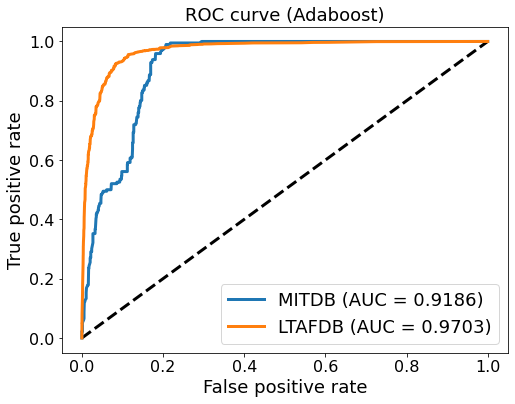

In [59]:
# auc_ada = metrics.roc_auc_score(y_test, y_score_adaboost)
auc_ada_A = metrics.roc_auc_score(y_A, y_score_adaboost_A)
auc_ada_long = metrics.roc_auc_score(y_long, y_score_adaboost_long)

# fpr_ada, tpr_ada, thresholds_ada = metrics.roc_curve(y_test, y_score_adaboost)
fpr_ada_A, tpr_ada_A, thresholds_ada_A = metrics.roc_curve(y_A, y_score_adaboost_A)
fpr_ada_long, tpr_ada_long, thresholds_ada_long = metrics.roc_curve(y_long, y_score_adaboost_long)


plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--', linewidth=3) # dashed line with black(k) color

# plt.plot(fpr_ada, tpr_ada, label='AFDB (AUC = %0.4f)' % auc_ada, linewidth=3)
plt.plot(fpr_ada_A, tpr_ada_A, label='MITDB (AUC = %0.4f)' % auc_ada_A, linewidth=3)
plt.plot(fpr_ada_long, tpr_ada_long, label='LTAFDB (AUC = %0.4f)' % auc_ada_long, linewidth=3)

plt.xlabel('False positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('ROC curve (Adaboost)', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

### Confusion matrix for AdaBoost algorithm for $N$=20 (you may plot confusion matrix for other classifiers and other segment lengths as well by running this script and change the "seg_len" above to 10 and 60)

In [75]:
cm_svm_A = confusion_matrix(y_A, y_pred_svm_A)
cm_dt_A = confusion_matrix(y_A, y_pred_dt_A)
cm_rf_A = confusion_matrix(y_A, y_pred_rf_A)
cm_stacking_A = confusion_matrix(y_A, y_pred_stacking_A)
cm_xgboost_A = confusion_matrix(y_A, y_pred_xgboost_A)
cm_adaboost_A = confusion_matrix(y_A, y_pred_adaboost_A)

cm_svm_long = confusion_matrix(y_long, y_pred_svm_long)
cm_dt_long = confusion_matrix(y_long, y_pred_dt_long)
cm_rf_long = confusion_matrix(y_long, y_pred_rf_long)
cm_stacking_long = confusion_matrix(y_long, y_pred_stacking_long)
cm_xgboost_long = confusion_matrix(y_long, y_pred_xgboost_long)
cm_adaboost_long = confusion_matrix(y_long, y_pred_adaboost_long)

cm_svm_nsr = confusion_matrix(y_nsr, y_pred_svm_nsr)
cm_dt_nsr = confusion_matrix(y_nsr, y_pred_dt_nsr)
cm_rf_nsr = confusion_matrix(y_nsr, y_pred_rf_nsr)
cm_stacking_nsr = confusion_matrix(y_nsr, y_pred_stacking_nsr)
cm_xgboost_nsr = confusion_matrix(y_nsr, y_pred_xgboost_nsr)
cm_adaboost_nsr = confusion_matrix(y_nsr, y_pred_adaboost_nsr)

target_names = ['Normal', 'AFIB']

In [78]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title, fontsize=14)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)

#### COnfusion matrix for MITDB 

In [1]:
plot_confusion_matrix(cm=cm_adaboost_A, normalize=True, classes=['Normal','AFIB'])

#### COnfusion matrix for LTAFDB

In [2]:
plot_confusion_matrix(cm=cm_adaboost_long, normalize=True, classes=['Normal','AFIB'])